# Refinement with bumps-dream PbSO4

In [32]:
# esyScience, technique-independent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_context('notebook')

# esyScience, diffraction
from easyDiffractionLib import Phases
from easyDiffractionLib.sample import Sample as Job
from easyDiffractionLib.interface import InterfaceFactory as Calculator
from easyDiffractionLib.elements.Experiments.Pattern import Pattern1D
from easyDiffractionLib.elements.Backgrounds.Point import PointBackground, BackgroundPoint
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters as CWParams

from easyCore.Fitting.Fitting import Fitter

## Helper functions

In [36]:
# help functions

def print_parameters(job):
    """ Print all fit-parameters in job. """
    for x in job.get_fit_parameters():
        print(x)
    

def compute_rmse(y_target, y_predicted):
    """ Compute root mean squared error (RMSE) between target and predicted values """
    delta_y = y_target - y_predicted
    rmse = np.sqrt(np.mean(delta_y**2))
    return rmse

def compute_mse_weighted(y_target, y_predicted):
    """ Compute the weighted mean squared error. (weighting by y_target) """
    delta_y = y_target - y_predicted
    weight = y_target
    mse_weighted = np.mean(delta_y**2 / weight)
    return mse_weighted

## Load the data and setup Job

In [37]:
# load cif
cif_fname = '../datasets/neutron_powder_PbSO4/PbSO4.cif'
phases = Phases.from_cif_file(cif_fname)

# load diffraction data
meas_fname = '../datasets/neutron_powder_PbSO4/D1A@ILL.xye'
meas_x, meas_y, meas_e = np.loadtxt(meas_fname, unpack=True)
print('Data shape:', meas_x.shape, meas_y.shape)

# setup interface to CrysPy and Job
calculator = Calculator(interface_name='CrysPy')
job = Job(phases=phases, parameters=CWParams(), interface=calculator)


Data shape: (2201,) (2201,)
Temp CIF: /tmp/easydiffraction_temp.cif


## Define which parameters to refine
Here the parameters to be refined are determined, and initial values are set rather close to the optimal solution in order for bumps-dream to converge quicker.

In [38]:
# setup 
job.parameters.wavelength = 1.912

# add background
bkg = PointBackground(linked_experiment='PbSO4')
bkg.append(BackgroundPoint.from_pars(meas_x[0], 200))
bkg.append(BackgroundPoint.from_pars(meas_x[-1], 250))
job.set_background(bkg)

# set which parameters to refine
job.pattern.scale.fixed = True
job.phases[0].scale.fixed = False
job.pattern.zero_shift.fixed = False
job.parameters.resolution_u.fixed = False
job.parameters.resolution_v.fixed = False
job.parameters.resolution_w.fixed = False
job.backgrounds[0][0].y.fixed = False
job.backgrounds[0][1].y.fixed = False

# set reasonable initial parameter values
if False:
    job.pattern.zero_shift = 0.125
    job.parameters.resolution_u = 0.17
    job.parameters.resolution_v = -0.38
    job.parameters.resolution_w = 0.4
    job.backgrounds[0][0] = 218
    job.backgrounds[0][1] = 230


print('Initial parameters:')
print_parameters(job)

Initial parameters:
<Parameter 'scale': 1.0+/-0, bounds=[0:inf]>
<Parameter 'resolution_u': 0.0002+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.0002+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.012+/-0, bounds=[-inf:inf]>
<Parameter 'zero_shift': 0.0+/-0, bounds=[-inf:inf]>
<Parameter 'intensity': 200.0+/-0, bounds=[-inf:inf]>
<Parameter 'intensity': 250.0+/-0, bounds=[-inf:inf]>


In [39]:
n_parameters = len(job.get_fit_parameters())
print(f'Number of parameters: {n_parameters}')

Number of parameters: 7


## Diffraction pattern before fitting

Initial: RMSE 417.279, MSE-weighted 171.943


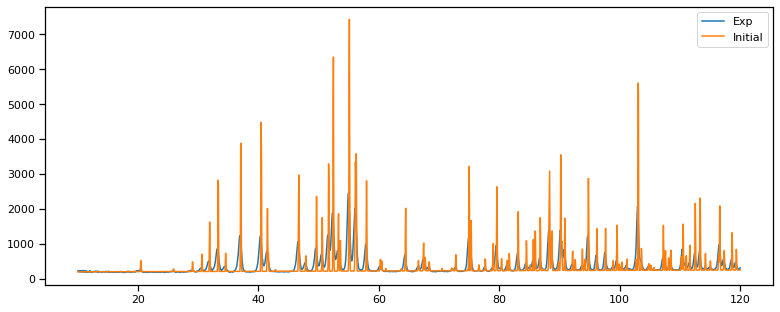

In [40]:
# Initial before fit
y_initial = calculator.fit_func(meas_x)
rmse_initial = compute_rmse(meas_y, y_initial)
msew_initial = compute_mse_weighted(meas_y, y_initial)
print(f'Initial: RMSE {rmse_initial:.3f}, MSE-weighted {msew_initial:.3f}')

# plot
fig = plt.figure(figsize=(11, 4.5))

plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_initial, label='Initial')
plt.legend()
fig.tight_layout()

## Fitting with bumps-dream
First, we switch the fit engine to bumps.

In [7]:
# setup fitting
fitter = Fitter(job, calculator.fit_func)
fitter.switch_engine('bumps')
print(job.get_fit_parameters())

[<Parameter 'scale': 1.0+/-0, bounds=[0:inf]>, <Parameter 'resolution_u': 0.0002+/-0, bounds=[-inf:inf]>, <Parameter 'resolution_v': -0.0002+/-0, bounds=[-inf:inf]>, <Parameter 'resolution_w': 0.012+/-0, bounds=[-inf:inf]>, <Parameter 'zero_shift': 0.0+/-0, bounds=[-inf:inf]>, <Parameter 'intensity': 200.0+/-0, bounds=[-inf:inf]>, <Parameter 'intensity': 250.0+/-0, bounds=[-inf:inf]>]


Next, we define the hyper-parameters to be used for the bumps-dream fitting.    
See the [bumps documentation](https://bumps.readthedocs.io/en/latest/) for more details

The MCMC is carried out by multiple independent "walkers".

* `n_steps` sets how many steps/iterations each walker will carry out
* `burn` specifys how many of the initial steps to throw away (equilibration period)
* `pop` sets how many walkers to use, the total number of walkers will be number of parameters times `pop`.
* `alpha` is a convergence criterion

Note also here that the weights are set to `sqrt(y)`, since weights will be passed as uncertainties to bumps.

In [9]:
# parameters
n_steps = 5000
burn = 50
thin = 1
pop = 1
alpha= 0.0001

# weights
weights = np.sqrt(meas_y)  # uncertainty in bumps (dy)

# run
kwargs = dict(samples=n_steps*pop*n_parameters, steps=n_steps, burn=burn, thin=thin, pop=pop, alpha=alpha,
              outliers='none', trim=False)
result = fitter.fit(meas_x, meas_y, weights=weights, method='dream', **kwargs)

# steps: 2000, # draws: 14000


## Summarize the refined parameters 

In [20]:
# print refined parameters
print_parameters(job)
y_refined = calculator.fit_func(meas_x)
rmse_refined = compute_rmse(meas_y, y_refined)
msew_refined = compute_mse_weighted(meas_y, y_refined)
print(f'Refined: RMSE {rmse_refined:.3f}, MSE-weighted {msew_refined:.3f}')

<Parameter 'scale': 1.207+/-0.004, bounds=[0:inf]>
<Parameter 'resolution_u': 0.197+/-0.014, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.480+/-0.026, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.481+/-0.011, bounds=[-inf:inf]>
<Parameter 'zero_shift': 0.1222+/-0.0009, bounds=[-inf:inf]>
<Parameter 'intensity': 197.4+/-1.0, bounds=[-inf:inf]>
<Parameter 'intensity': 240.0+/-1.2, bounds=[-inf:inf]>
Refined: RMSE 46.402, MSE-weighted 3.738


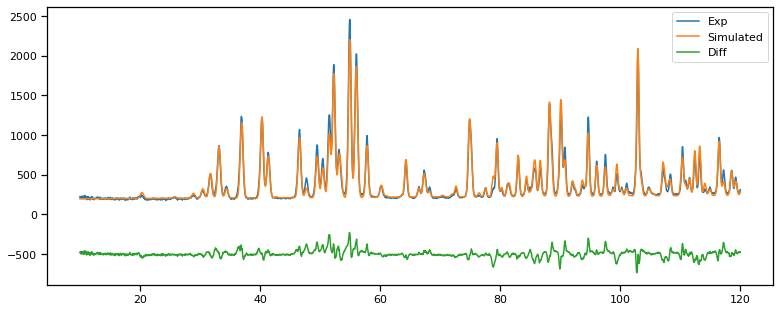

In [22]:
# plot refined diffraction pattern
fig = plt.figure(figsize=(11, 4.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_refined, label='Simulated')
plt.plot(meas_x, meas_y - y_refined-500, label='Diff')
plt.legend()
fig.tight_layout()

## Analysis of the MCMC data
From a bumps-dream fit you will get the best-parameters and their uncertainty (as above), but you can also access the full MCMC data via the `result.engine_result.state`.

This includes all the samples of the parameters and their corresponding log-posterior probability.

The parameters from bumps are in different order so first we find out which parameter is which.

In [17]:
# translate names
from easyCore.Fitting.fitting_template import NameConverter
keys = state.labels
bumps_parameter_names = []
for key in keys:
    num = int(key.replace('p', ''))
    name = NameConverter().get_name_from_key(num)
    bumps_parameter_names.append(name)
print(bumps_parameter_names)

['intensity', 'resolution_w', 'resolution_v', 'scale', 'intensity', 'resolution_u', 'zero_shift']


In [24]:
from bumps.dream.stats import var_stats

# extract MCMC-data
state = result.engine_result.state
steps, samples, logp = state.chains()

# collect the best parameters and their uncertainties
params = state.best()[0]
draw = state.draw()
vstats = var_stats(draw)
stderrs = np.array([(v.p68[1] - v.p68[0]) / 2 for v in vstats], 'd')

for n, v, e in zip(bumps_parameter_names, params, stderrs):
    print(f'{n:15} {v:12.5f} , err {e:8.5f}')

intensity          197.39548 , err  0.98944
resolution_w         0.48125 , err  0.01127
resolution_v        -0.47961 , err  0.02594
scale                1.20733 , err  0.00411
intensity          239.99907 , err  1.17029
resolution_u         0.19706 , err  0.01415
zero_shift           0.12222 , err  0.00087


Next, we'll plot the MCMC trajectory of the parameters for a few walkers

samples shape (2011, 7, 7)


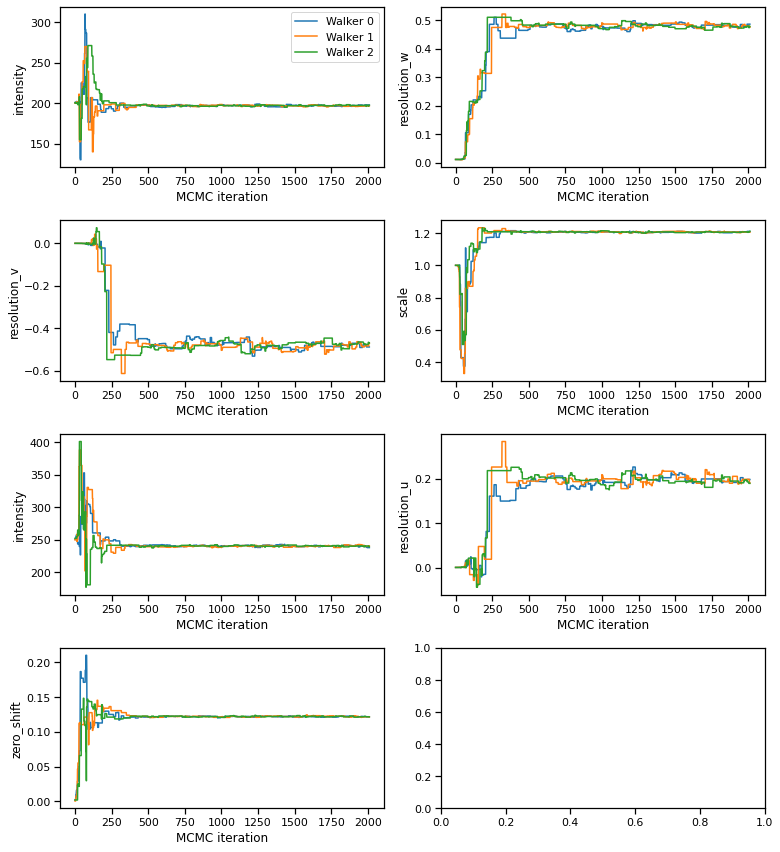

In [25]:
print('samples shape', samples.shape)
walkers_to_plot = [0, 1, 2]

fig, axes = plt.subplots(4, 2, figsize=(11, 12))
for i in range(n_parameters):
    ax = axes.flat[i]
    name = bumps_parameter_names[i]
    for walker_ind in walkers_to_plot:
        ax.plot(samples[:, walker_ind, i], label=f'Walker {walker_ind}')
    ax.set_ylabel(name)
    ax.set_xlabel('MCMC iteration')
    if i == 0:
        ax.legend(loc=1)
    
fig.tight_layout()
plt.show()

Next, we'll make a simple corner to visualize the full joint probability distribution over the parameters

samples shape (2011, 7, 7)
samples_flat shape (10577, 7)


<Figure size 864x864 with 0 Axes>

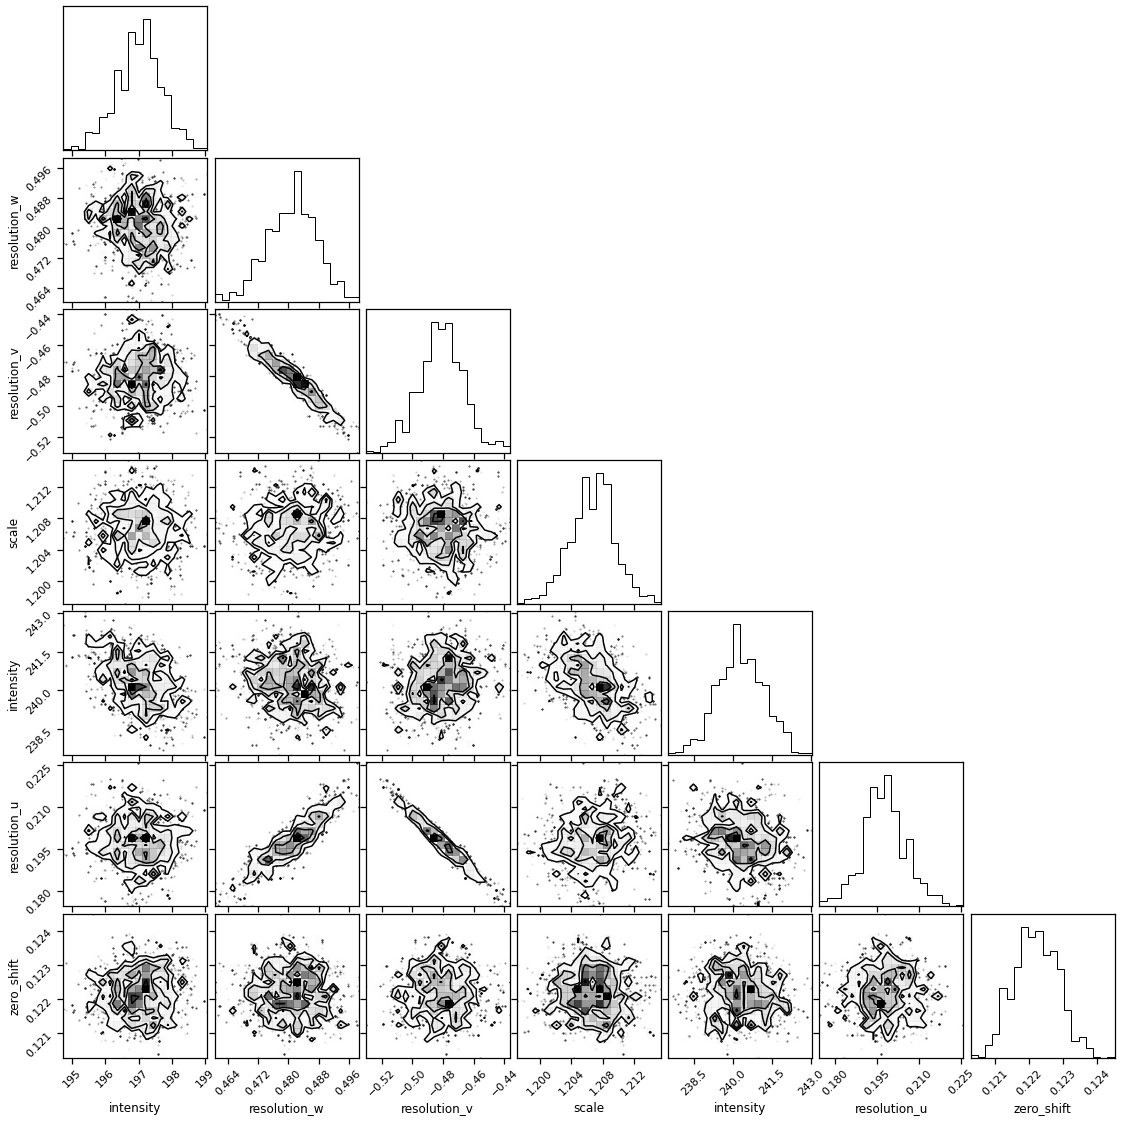

In [30]:
import corner

n_throw_away = 500  # if we need to throw away more equilibration steps

# flatten samples array
samples = samples[:, :, :]
print('samples shape', samples.shape)
samples_flat = samples[n_throw_away:, :, :].reshape(-1, n_parameters)
print('samples_flat shape', samples_flat.shape)

# corner plot
fig = plt.figure(figsize=(12, 12))
corner.corner(samples_flat, labels=bumps_parameter_names)
fig.tight_layout()

One can also visualize the MCMC data directly with the bumps-functionality.     
The figure produce may look somewhat strange due to naming of parameters inside easyDiffraction.

              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 p122952085940602782371583904145269285109  198.1(85)  197.15  197.40 [  196.3   198.2] [  191.9   216.8]
 2 p155740779970145512879795693608737978700   0.44(11)   0.480   0.481 [   0.46    0.49] [   0.01    0.50]
 3 p212844185325559325209200363483546411457  -0.42(15)  -0.478  -0.480 [  -0.50   -0.44] [  -0.53    0.00]
 4 p259347696394085463685385403113521395500   1.18(11)   1.207   1.207 [   1.20    1.21] [   0.88    1.23]
 5 p274511275003168191378506448493826458304    243(17)  240.28  240.00 [  239.2   241.6] [  227.8   286.0]
 6 p306815406074140306225773053966754502830  0.173(66)   0.196   0.197 [   0.18    0.21] [  -0.02    0.22]
 7 p313903257679066719872158679599635337937  0.121(15)  0.1222  0.1222 [  0.121   0.123] [  0.103   0.133]

Statistics and plots based on 14077 samples (100.0% of total samples drawn)


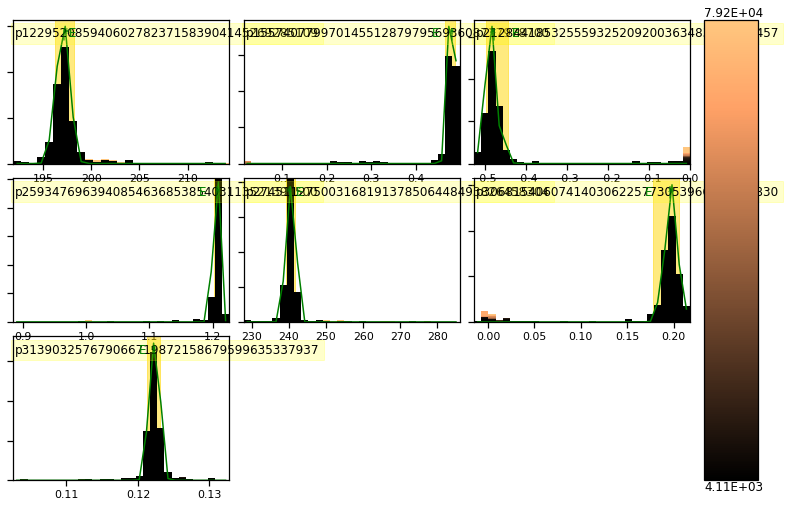

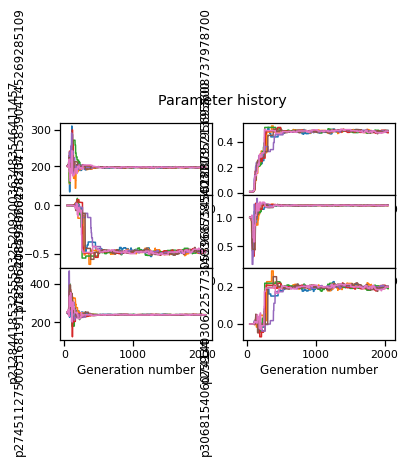

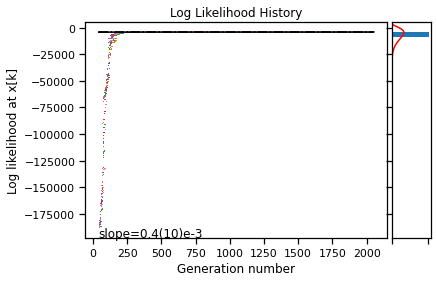

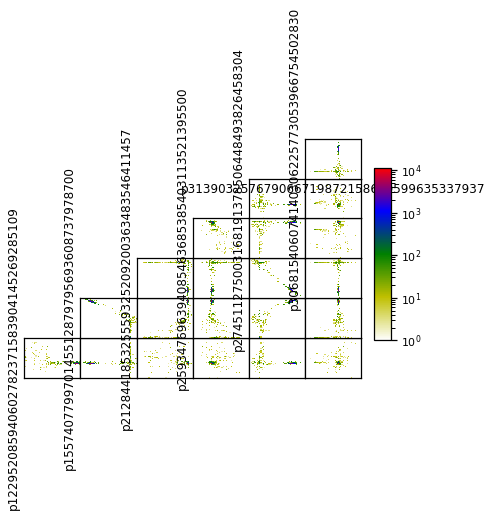

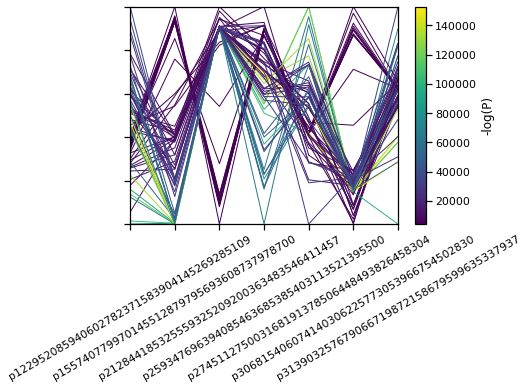

In [31]:
state.show()